---
title: Heatwave in Netherlands 
subtitle: Learn how to use the EOPF Jupyter Notebook template
authors:
  - name: Yuvraj Adagale
    orcid: 0009-0008-1259-3399
    github: Yuvraj198920
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
thumbnail: https://raw.githubusercontent.com/EOPF-Sample-Service/eopf-sample-notebooks/refs/heads/main/notebooks/static/ESA_logo_2020_Deep.png
keywords : earth and related environmental sciences
releaseDate: 2025-01-29
datePublished: 2025-01-29
dateModified: 2025-02-01
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

# Table of Contents

1. [Introduction](#introduction)
    - [Notebook Overview](#notebook-overview)
    - [Objectives](#objectives)
2. [Setup](#setup)
    - [Import Required Libraries](#import-required-libraries)
    - [Dask Cluster Initialization](#dask-cluster-initialization)
    - [Read AOI and Dates](#read-aoi-and-dates)
    - [Visualize Area of Interest](#visualize-area-of-interest)
3. [Data Access](#data-access)
    - [List of Available Remote Files](#list-of-available-remote-files)
    - [Group Files by Shape](#group-files-by-shape)
4. [Data Loading](#data-loading)
    - [Preprocessing Sentinel-3 Data](#preprocessing-sentinel-3-data)
    - [Load Measurements Group](#load-measurements-group)
    - [Load Quality Group](#load-quality-group)
    - [Merge Groups Into Single Dataset](#merge-groups-into-single-dataset)
5. [Next Steps / Analysis](#next-steps--analysis)

---


## Introduction

---

### Notebook Overview

(Introduction)=

As an impact of global warming, an increase in temperature has been reported, which can lead to potential health risks and environmental stress. Several research studies have been presented over the years, such as in this [paper](https://www.mdpi.com/2072-4292/14/3/561), where they explain the change in Land surface temperature over several regions.

Thus, in this notebook, we want to showcase a tool for mapping heatwaves using Sentinel-3 products. For this, we focused on the Netherlands and used specific conditions proposed by the [“National Heatwave Plan”](https://www.rivm.nl/en/heat/national-heatwave-plan) in the Netherlands. The condition implies:

```
5 days >25 and 3 days >30
```

Moreover, in De Bilt, a municipality in the province of Utrecht had a temperature of 25°C at least five days in a row, with at least three days hotter than 30 °C.


This notebook demonstrates how to analyze and visualize heatwave events in the Netherlands using Sentinel-3 Land Surface Temperature (LST) data in Zarr format. Leveraging the EOPF (Earth Observation Processing Framework) and Jupyter Notebook template, you will learn how to efficiently access, process, and interpret large volumes of satellite data from cloud object storage.

The workflow will guide you through:

- Accessing and filtering Sentinel-3 LST datasets for a specific time range and area of interest (AOI)
- Grouping and reading Zarr data in parallel using Dask for scalable analysis
- Merging measurement and quality datasets to enable robust computation
- Preparing data for downstream tasks such as heatwave detection, cloud masking, and visualization

By the end of this notebook, you will gain practical skills for working with cloud-based geospatial time series using Python, and a deeper understanding of environmental monitoring with open satellite data.

:::{hint} Overview

**Questions**
- How does the notebook load and merge Sentinel-3 LST data from remote Zarr files?
- What strategies are used to preprocess the data and maintain nanosecond precision in timestamps?
- How does the workflow filter datasets based on a specific date range and geographic area of interest?
- What role does Dask play in enabling efficient parallel data processing?
- How is the heatwave detection algorithm implemented using 5-day rolling sums and threshold conditions?
  
**Objectives**
- Demonstrate how to access and process Sentinel-3 LST data in Zarr format using EOPF tools
- Show practical steps for identifying and analyzing heatwave events in the Netherlands
:::

(Setup)=
## Setup

---
In this section, we prepare our environment by ensuring the necessary libraries are available. Although most libraries are already imported in previous cells, this step outlines the essential packages used for data handling, visualization, and geospatial analysis.

### Import Required Libraries

In [20]:
import xarray as xr
from distributed import LocalCluster
import folium
from datetime import datetime
import s3fs
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import json
from scipy.interpolate import griddata
from pathlib import Path
import geopandas as gpd

In [2]:
xr.set_options(keep_attrs=True)

Check xarray, dask, and zarr versions to ensure compatibility with the EOPF-Zarr format.

In [3]:
xr.__version__

'2024.7.0'

### Dask Cluster Initialization


This creates a local Dask cluster and retrieves its client for distributed parallel processing.


In [4]:
cluster = LocalCluster()
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 31.34 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41633,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 31.34 GiB
Comm: tcp://127.0.0.1:42925,Total threads: 2
Dashboard: http://127.0.0.1:39941/status,Memory: 7.83 GiB
Nanny: tcp://127.0.0.1:40909,


### Read AOI and Dates

In [5]:
def read_json(filename: str) -> dict:
    with open(filename) as input:
        field = json.load(input)
    return field


date = ["2023-06-01", "2023-10-30"]
aoi = read_json("netherlands_export.geojson")

### Visualize Area of Interest

In [6]:
m = folium.Map([52.2, 5], zoom_start=7)
folium.GeoJson(aoi).add_to(m)
m

Calculate the extent of geojson

In [7]:
def calculate_geojson_extent(geojson_path):
    with open(geojson_path) as f:
        geojson_data = json.load(f)
    gdf = gpd.GeoDataFrame.from_features(geojson_data["features"]).explode().cx[0:, :]
    return gdf.total_bounds


geojson_path = Path("netherlands_export.geojson")
extent = calculate_geojson_extent(geojson_path)
print(f"Extent of the geojson: {extent}")

Extent of the geojson: [ 3.349415 50.74755   7.198506 53.558092]


/tmp/ipykernel_1570159/414639890.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf = gpd.GeoDataFrame.from_features(geojson_data["features"]).explode().cx[0:, :]


## Data Access

We now want to access a time series of Sentinel-3 data to compute the daily heatwave values, remove cloudy pixels, and perform other processing steps.

---
### List of Available Remote Files

In [8]:
bucket = "e05ab01a9d56408d82ac32d69a5aae2a:sample-data"
prefixes = ["tutorial_data/cpm_v253/", "tutorial_data/cpm_v256/"]
prefix_url = "https://objectstore.eodc.eu:2222"
start_date = datetime(2023, 6, 1)
end_date = datetime(2023, 10, 30)

fs = s3fs.S3FileSystem(anon=True, client_kwargs={"endpoint_url": prefix_url})

# Unregister CEPH handler (required for EODC)
handlers = fs.s3.meta.events._emitter._handlers
handlers_to_unregister = handlers.prefix_search("before-parameter-build.s3")
fs.s3.meta.events._emitter.unregister(
    "before-parameter-build.s3", handlers_to_unregister[0]
)

filtered_urls = []

for prefix in prefixes:
    # Find all potential Sentinel-3 LST datasets
    s3_pattern = f"s3://{bucket}/{prefix}S3[AB]_SL_2_LST____*.zarr"
    candidates = fs.glob(s3_pattern)

    for s3_path in candidates:
        # Convert S3 path to HTTP URL
        http_url = f"{prefix_url}/{s3_path.replace('s3://', '')}"

        # Extract filename from URL
        filename = s3_path.split("/")[-1]

        # Parse sensing start time (4th segment after splitting by '_')
        try:
            # Split: S3B_SL_2_LST____20231029T203741_20231029T204041_...
            time_segment = filename.split("____")[1]
            sensing_start = time_segment.split("_")[0]  # 20231029T203741
            file_date = datetime.strptime(sensing_start[:8], "%Y%m%d")

            if start_date <= file_date <= end_date:
                filtered_urls.append(http_url)

        except (IndexError, ValueError):
            print(f"Skipping malformed filename: {filename}")
            continue

print(
    f"Found {len(filtered_urls)} datasets between {start_date.date()} and {end_date.date()}"
)

Found 1050 datasets between 2023-06-01 and 2023-10-30


### Preprocessing with subsetting, masking, and regridding Sentinel-3 Data 

In [47]:
def preprocess_slstr(ds):
    """Preprocess SLSTR data: apply cloud mask, subset for Netherlands, and regrid with square pixels."""
    file_path = ds.encoding["source"]
    filename = file_path.split("/")[-1]
    time_str = filename.split("____")[1].split("_")[0]
    dt = datetime.strptime(time_str, "%Y%m%dT%H%M%S")
    time_ns = np.datetime64(dt, "ns")

    # Load 'quality' group from the same Zarr file
    ds_qual = xr.open_dataset(file_path, engine="zarr", group="quality")

    # Apply cloud masking using 'confidence_in' from quality group
    confidence_in = ds_qual["confidence_in"]
    cloud_mask = confidence_in >= 16384  # Threshold for cloud-free data
    masked_lst = ds["lst"].where(cloud_mask)

    # Define Netherlands bounding box
    lon_min, lat_min, lon_max, lat_max = 3.2, 50.75, 7.2, 53.5  # Netherlands extent
    mask = (
        (ds["longitude"] >= lon_min)
        & (ds["longitude"] <= lon_max)
        & (ds["latitude"] >= lat_min)
        & (ds["latitude"] <= lat_max)
    )

    rows, cols = np.where(mask)
    if len(rows) == 0 or len(cols) == 0:
        print(f"No data points found within Netherlands bounds for {filename}")
        return None

    row_min, row_max = rows.min(), rows.max()
    col_min, col_max = cols.min(), cols.max()

    # Subset the masked LST and coordinates
    masked_lst_subset = masked_lst.isel(
        rows=slice(row_min, row_max + 1), columns=slice(col_min, col_max + 1)
    )
    lat2d = ds["latitude"].isel(
        rows=slice(row_min, row_max + 1), columns=slice(col_min, col_max + 1)
    )
    lon2d = ds["longitude"].isel(
        rows=slice(row_min, row_max + 1), columns=slice(col_min, col_max + 1)
    )

    # Regrid with square pixels using resolution
    target_resolution = 0.01
    n_points_lat = int(np.ceil((lat_max - lat_min) / target_resolution)) + 1
    n_points_lon = int(np.ceil((lon_max - lon_min) / target_resolution)) + 1
    lon_grid, lat_grid = np.meshgrid(
        np.linspace(lon_min, lon_max, n_points_lon),
        np.linspace(lat_min, lat_max, n_points_lat),
    )

    regridded_lst = griddata(
        (lon2d.values.ravel(), lat2d.values.ravel()),
        masked_lst_subset.values.ravel(),
        (lon_grid, lat_grid),
        method="nearest",
    )

    # Create a new dataset with regridded data
    regridded_ds = xr.Dataset(
        data_vars={"lst": (["lat", "lon"], regridded_lst)},
        coords={"lat": lat_grid[:, 0], "lon": lon_grid[0, :], "time": time_ns},
    )

    return regridded_ds

### Load and process data

In [48]:
ds_meas = xr.open_mfdataset(
    filtered_urls,  # List of Zarr file paths
    engine="zarr",
    group="measurements",
    preprocess=preprocess_slstr,
    combine="nested",
    concat_dim="time",
    chunks="auto",
    parallel=True,
    consolidated=True,
)

In [49]:
ds_meas

<xarray.Dataset> Size: 930MB
Dimensions:  (time: 1050, lat: 276, lon: 401)
Coordinates:
  * lat      (lat) float64 2kB 50.75 50.76 50.77 50.78 ... 53.48 53.49 53.5
  * lon      (lon) float64 3kB 3.2 3.21 3.22 3.23 3.24 ... 7.17 7.18 7.19 7.2
  * time     (time) datetime64[ns] 8kB 2023-06-01T09:36:33 ... 2023-10-29T20:...
Data variables:
    lst      (time, lat, lon) float64 930MB nan nan nan nan ... nan nan nan nan

In [50]:
ds_meas_grouped = ds_meas.groupby("time.date").max("time")
ds_meas_grouped

<xarray.Dataset> Size: 134MB
Dimensions:  (date: 151, lat: 276, lon: 401)
Coordinates:
  * lat      (lat) float64 2kB 50.75 50.76 50.77 50.78 ... 53.48 53.49 53.5
  * lon      (lon) float64 3kB 3.2 3.21 3.22 3.23 3.24 ... 7.17 7.18 7.19 7.2
  * date     (date) object 1kB 2023-06-01 2023-06-02 ... 2023-10-28 2023-10-29
Data variables:
    lst      (date, lat, lon) float64 134MB 284.6 285.1 284.8 ... 284.7 284.7

### Analyze monthly heatwave events across the Netherlands in 2023 and a visualise the results
**Land Surface Temperature (LST) is in kelvin**

1. **Load the heatwave data for the Netherlands in 2023**
2. **Filter the data for the month of July 2023**
3. **Count the number of heatwave days for each latitude and longitude**
4. **Visualize the heatwave days using a heatmap**

Regridded dataset shape: (1050, 276, 401)
Time range: 2023-06-01T09:36:33.000000000 to 2023-10-29T21:13:36.000000000
Heatwave count shape: (276, 401)
Number of NaN values in heatwave count: 108269


<Figure size 1400x1200 with 0 Axes>

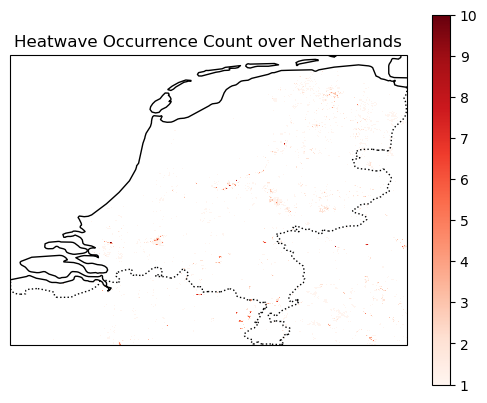

In [54]:
def detect_heatwaves(combined_data):
    """Detect heatwaves over a 5-day window with temperature thresholds."""
    if "date" not in combined_data.dims:
        raise ValueError("Date dimension not found in combined data")

    lst_array = combined_data["lst"].values
    time_steps = lst_array.shape[0]

    heatwave_flags = np.zeros(
        (time_steps - 4, combined_data.lat.size, combined_data.lon.size), dtype=bool
    )

    for i in range(time_steps - 4):
        ar_sub = lst_array[i : i + 5]
        heatwave_flags[i] = (np.all(ar_sub > 295, axis=0)) & (
            np.nansum(ar_sub > 300, axis=0) > 2
        )

    heatwave_da = xr.DataArray(
        heatwave_flags,
        dims=["time", "lat", "lon"],
        coords={
            "time": combined_data.date.values[:-4],
            "lat": combined_data.lat,
            "lon": combined_data.lon,
        },
    )

    heatwave_count = heatwave_da.sum(dim="time")
    return heatwave_count


if ds_meas_grouped is not None:
    # Detect heatwaves
    heatwave_count = detect_heatwaves(ds_meas_grouped)

    # Compute results
    ds_meas_grouped = ds_meas_grouped.compute()
    heatwave_count = heatwave_count.compute()
    # Apply the original notebook's 0-to-NaN transformation
    heatwave_count = heatwave_count.astype(float)  # Convert to float to allow NaN
    heatwave_count.values[heatwave_count == 0] = np.nan  # Replace 0s with NaN

    # Print diagnostics
    print("Regridded dataset shape:", ds_meas.lst.shape)
    print(f"Time range: {ds_meas.time.min().values} to {ds_meas.time.max().values}")
    print("Heatwave count shape:", heatwave_count.shape)
    print(
        "Number of NaN values in heatwave count:", heatwave_count.isnull().sum().values
    )
    plt.figure(figsize=(14, 12))
    fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
    mappable = heatwave_count.plot.pcolormesh(
        ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree(), cmap="Reds"
    )
    ax.set_extent([3.349415, 7.198506, 50.74755, 53.558092], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    plt.title("Heatwave Occurrence Count over Netherlands")
    plt.show()
# Clean up
client.close()

In [55]:
# Function to plot heatwave count on a grid
def plot_heatwave_grid(heatwave_count):
    """Plot heatwave count as a 2D grid."""
    plt.figure(figsize=(10, 8))
    heatwave_count.plot.imshow(x="lon", y="lat", cmap="Reds")
    plt.title("Heatwave Occurrence Count (Grid View) - Netherlands")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


# Before scatter plotting, we need to convert the 2D grid to 1D arrays
def plot_heatwave_scatter(heatwave_count):
    """Plot heatwave count as a scatter plot."""
    # Convert 2D grid to 1D arrays for scatter plot
    lon_mesh, lat_mesh = np.meshgrid(
        heatwave_count.lon.values, heatwave_count.lat.values
    )

    # Flatten the arrays for scatter plotting
    lon_flat = lon_mesh.flatten()
    lat_flat = lat_mesh.flatten()
    heatwave_flat = heatwave_count.values.flatten()

    # Only plot non-NaN values
    mask = ~np.isnan(heatwave_flat)

    plt.figure(figsize=(10, 8))
    sc = plt.scatter(
        lon_flat[mask],
        lat_flat[mask],
        c=heatwave_flat[mask],
        cmap="Reds",
        s=10,
        alpha=0.7,
    )
    plt.colorbar(sc, label="Heatwave Days")
    plt.title("Heatwave Occurrence Count (Scatter Plot) - Netherlands")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()


def plot_regridded_lst(ds):
    plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([3.349415, 7.198506, 50.74755, 53.558092], crs=ccrs.PlateCarree())

    # Add coastlines and gridlines
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.gridlines(draw_labels=True)

    # Plot the regridded LST data
    ds.plot.pcolormesh(
        ax=ax,
        cmap="viridis",
        add_colorbar=True,
        cbar_kwargs={"label": "LST (K)"},
        transform=ccrs.PlateCarree(),
    )

    plt.title("Regridded LST")
    plt.show()


# Function to plot heatwave count on a world map with proper colorbar handling
def plot_heatwave_world_map(heatwave_count):
    """Plot heatwave count on a world map with Netherlands focus."""
    plt.figure(figsize=(14, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot heatwave count and save the returned mappable
    heatwave_count.plot.pcolormesh(
        ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree(), cmap="Reds", alpha=0.7
    )

    # Set a narrower extent to zoom in more on the Netherlands
    ax.set_extent(
        [3.0, 7.5, 50.0, 54.5], crs=ccrs.PlateCarree()
    )  # Slightly zoomed out view of Netherlands
    ax.coastlines(resolution="10m")  # Higher resolution coastlines
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
    ax.add_feature(cfeature.LAND, facecolor="lightgray")

    # Add more detailed features for better visualization
    ax.add_feature(cfeature.RIVERS, alpha=0.5)
    ax.add_feature(cfeature.LAKES, alpha=0.5)

    # Create colorbar using the saved mappable

    plt.title("Heatwave Occurrence Count - Netherlands")


# Fix the function first to handle NaN values
def plot_heatwave_folium(heatwave_count):
    data = heatwave_count.values
    lat = heatwave_count.lat.values
    lon = heatwave_count.lon.values

    map_center = [np.mean(lat), np.mean(lon)]
    m = folium.Map(location=map_center, zoom_start=7)

    # Create a copy of data for visualization
    viz_data = np.copy(data)
    # Replace NaN with a visible color for visualization
    max_value = np.nanmax(viz_data)

    # Create a custom colormap function that handles NaN values
    def color_function(x):
        if np.isnan(x):
            return (0, 0, 0, 0)  # Transparent for NaN values
        else:
            intensity = min(255, int((x / max_value) * 255))
            return (intensity, 0, 0, 0.7)  # Red with 70% opacity

    bounds = [[lat.min(), lon.min()], [lat.max(), lon.max()]]
    folium.raster_layers.ImageOverlay(
        image=viz_data,
        bounds=bounds,
        mercator_project=True,
        opacity=0.7,
        colormap=color_function,
    ).add_to(m)

    return m

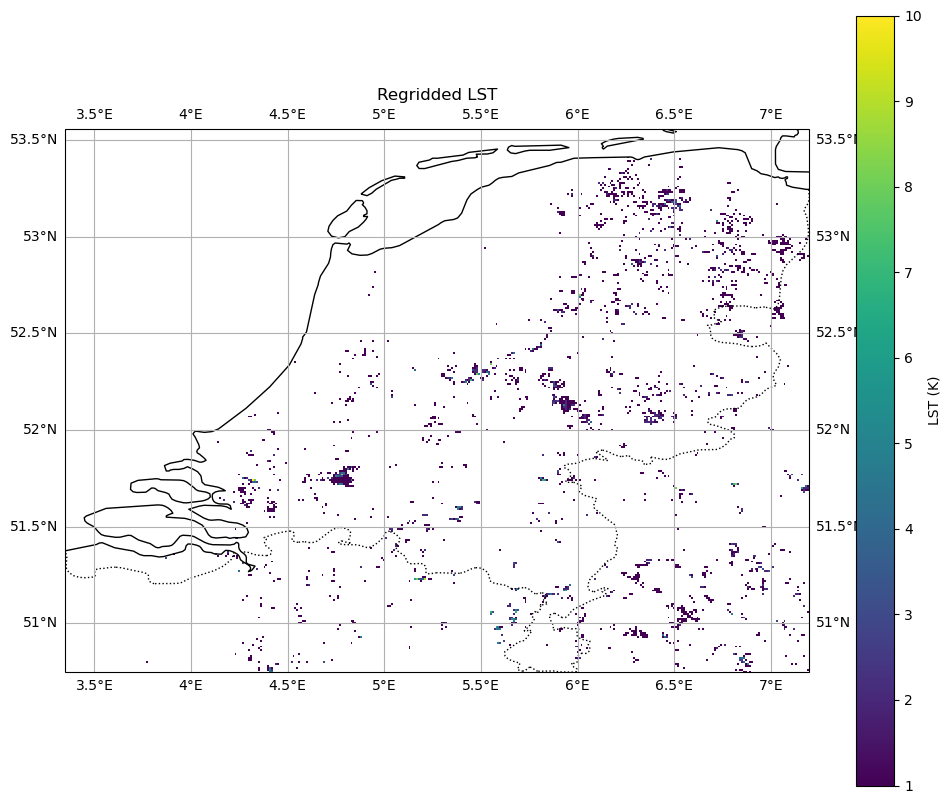

In [56]:
plot_regridded_lst(heatwave_count)

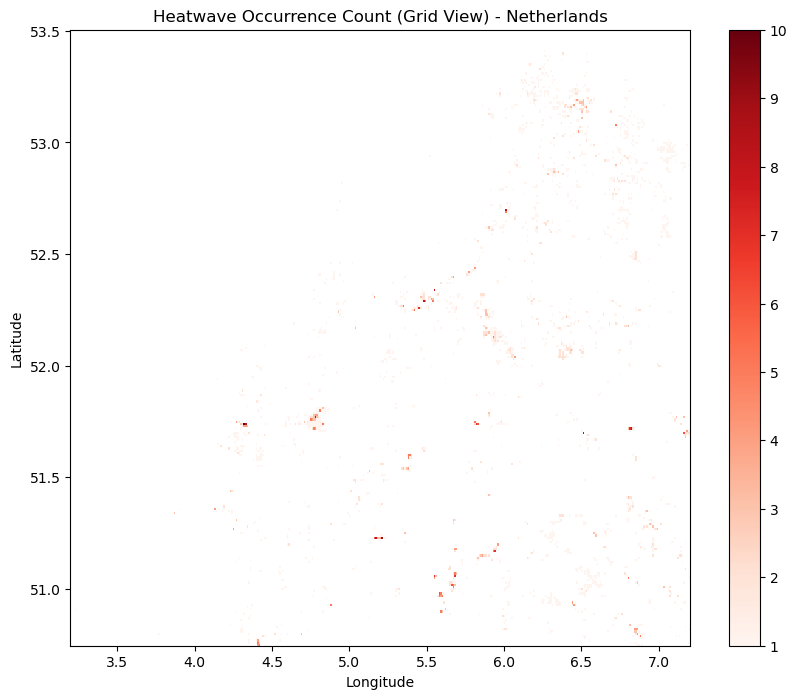

In [57]:
plot_heatwave_grid(heatwave_count)

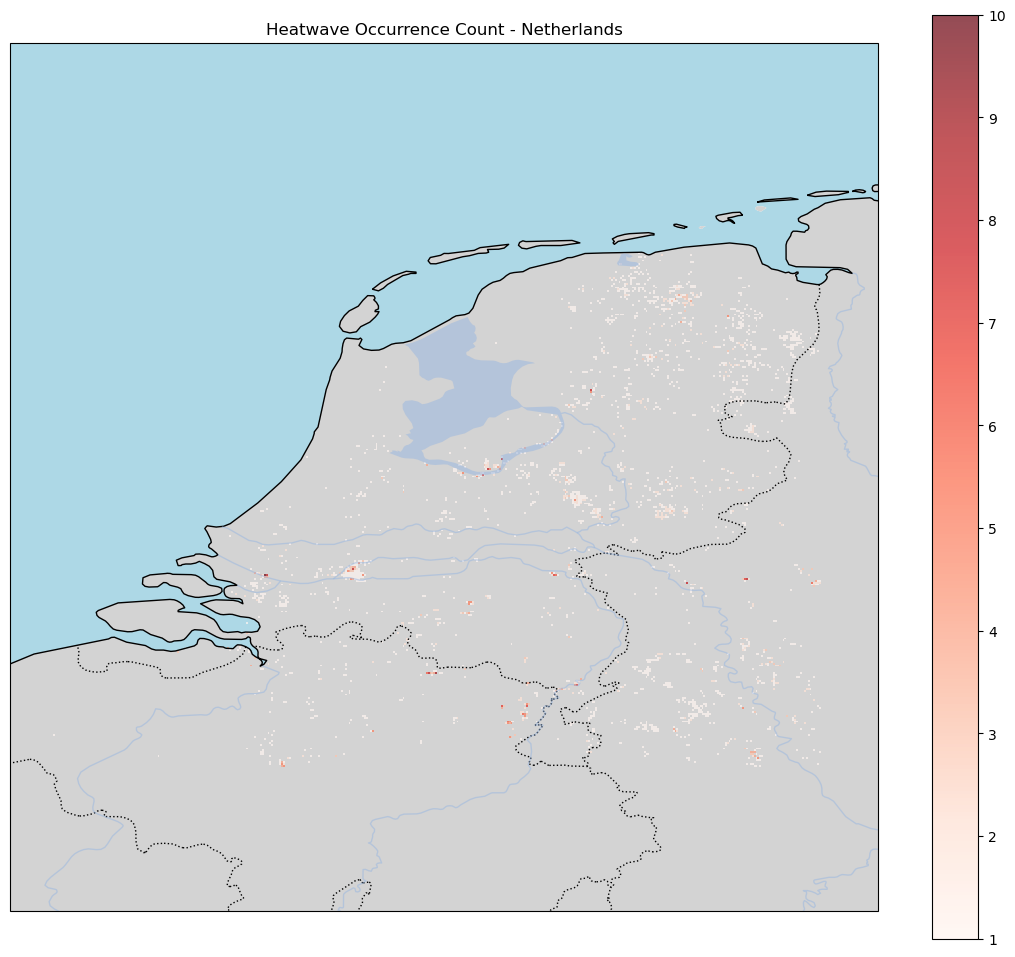

In [58]:
plot_heatwave_world_map(heatwave_count)

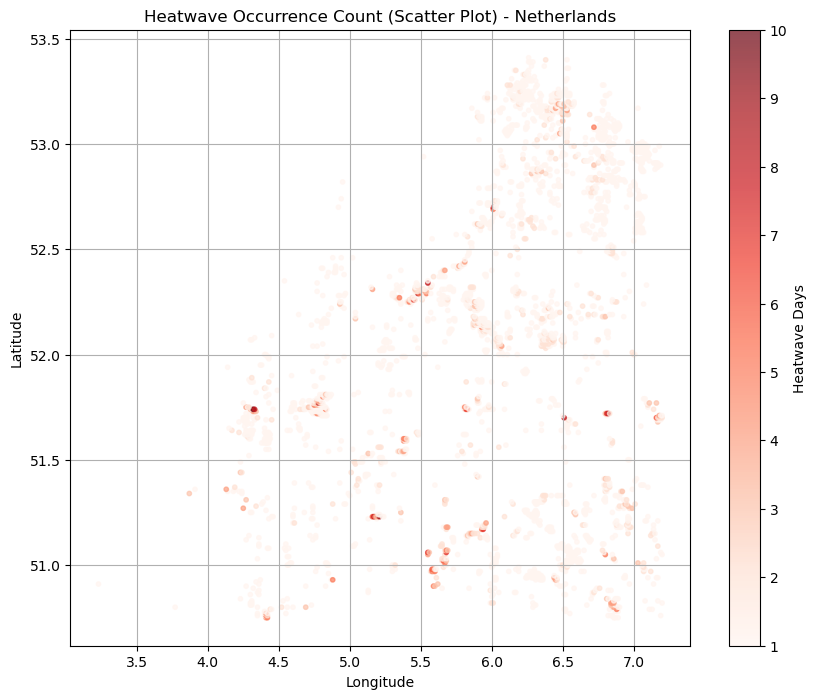

In [59]:
plot_heatwave_scatter(heatwave_count)


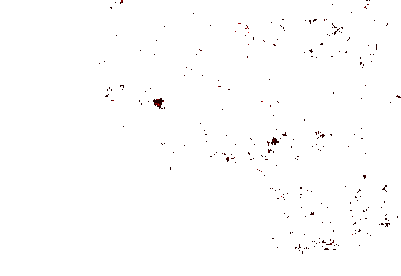

In [60]:
m = plot_heatwave_folium(heatwave_count)
m

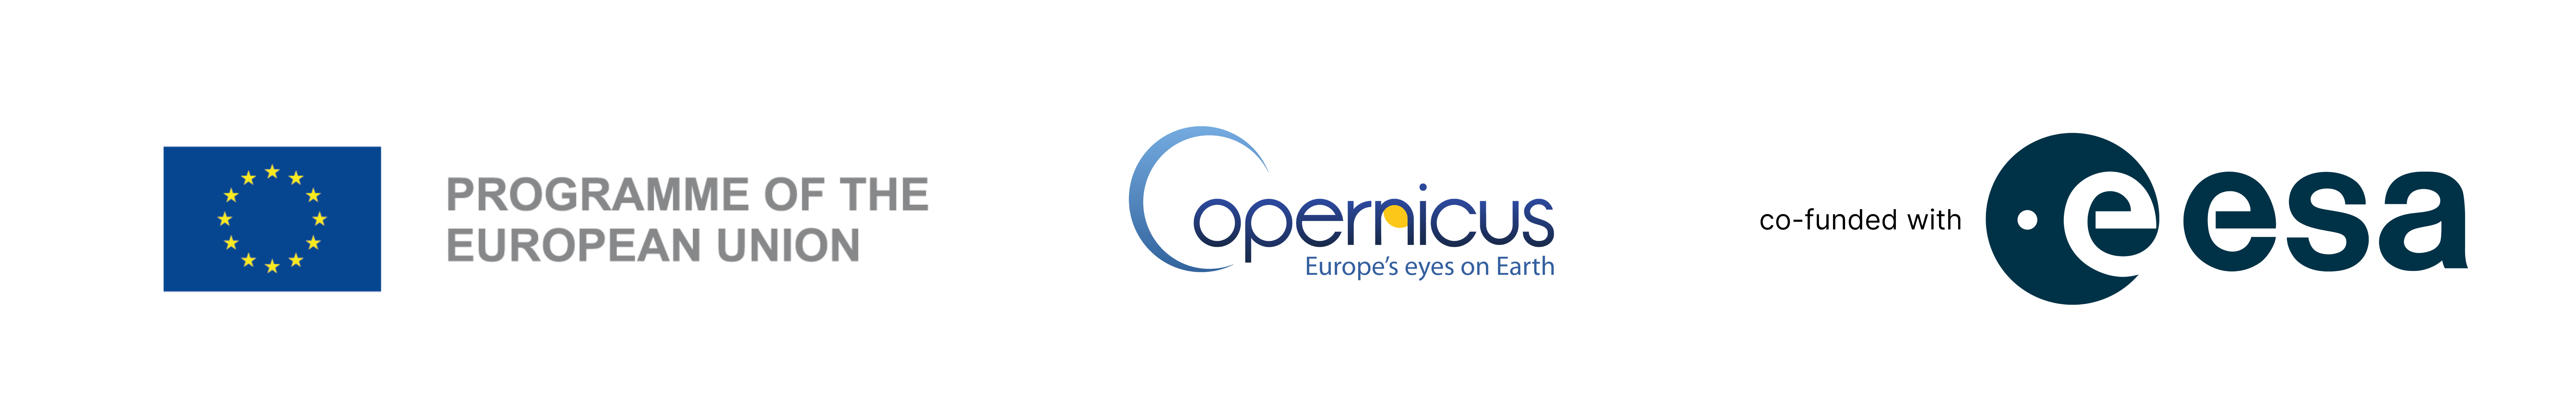